In [1]:
import pygplates
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def get_unique_plate_pairs_from_rotation_model(rotation_model,recon_time):
    # given a rotation model and a specifief reconstruction time, return 
    # a list of the unique plate pairs
    
    tree = rotation_model.get_reconstruction_tree(recon_time)
    edges = tree.get_edges()
    # Get a list of plate pairs
    tree_list = []
    for edge in edges:
        if edge.get_parent_edge() is not None:
            tree_list.append((edge.get_fixed_plate_id(),edge.get_parent_edge().get_fixed_plate_id()))

    # get unique list (remove duplicates)
    uniq_plate_pairs_from_rotations = list(set(tree_list))

    return uniq_plate_pairs_from_rotations


def get_unique_plate_ids_from_reconstructed_features(reconstructed_features):
    # given a set of reconstructed features, return a list of the unique plate ids
    
    feature_plate_ids = []
    for reconstructed_feature in reconstructed_features:
        feature_plate_ids.append(reconstructed_feature.get_feature().get_reconstruction_plate_id())
    unique_plate_ids = list(set(feature_plate_ids))
    
    return unique_plate_ids


# function to get centroid from every polygon in the reconstructed static polygons
def GetPolygonCentroid(static_polygons,plateid):
    centroid = []  
    target_polygon_area = 0
    for polygon in static_polygons:
        if polygon.get_feature().get_reconstruction_plate_id()==plateid:
            if polygon.get_reconstructed_geometry() is not None:
                if polygon.get_reconstructed_geometry().get_area()>target_polygon_area:
                    centroid = polygon.get_reconstructed_geometry().get_boundary_centroid().to_lat_lon()
                    target_polygon_area = polygon.get_reconstructed_geometry().get_area()
    
    return centroid


# Alternatively, get centroids of topological polygons
def GetPlateCentroid(resolved_polygons,plateid):
    centroid = []    
    for polygon in resolved_polygons:
        if polygon.get_feature().get_reconstruction_plate_id()==plateid:
            centroid = polygon.get_resolved_boundary().get_boundary_centroid().to_lat_lon()
    
    return centroid


def patch_links_between_polygon(moving_plate,uniq_rotation_pairs,uniq_plates_from_static_polygons):
    # for a given plate id, find the next highest plate id in the hierarchy
    # for which a geometry exists in the specified set of polygons
    
    # the first entry in the returned list is always the input moving plate
    plate_chain_list = [moving_plate]
    
    fixed_plate = None
    found_the_end = False
    while not found_the_end:
        
        # first, find the plate pair (from the rotation tree) for the input moving plate. 
        # Append the fixed plate to our list
        for plate_pair in uniq_rotation_pairs:
            if plate_pair[0]==moving_plate:
                fixed_plate = plate_pair[1]
                plate_chain_list.append(fixed_plate)
                continue
        
        # if fixed plate is still None, we didn't find a valid plate pair - exit
        if fixed_plate is None:
            found_the_end = True
        # if fixed plate id has a valid geoemtry, we're done - exit 
        elif fixed_plate in uniq_plates_from_static_polygons:
            found_the_end = True
        # if fixed plate id doesn't have a valid id, set the fixed plate to be moving plate
        # and start the loop again
        else:
            moving_plate = fixed_plate
        
        # Note that this is important to stop infinite loop when the fixed plate becomes zero
        # Not sure why the 'None' doesn't kick in?
        if fixed_plate==0:
            break
                   
    return plate_chain_list   
                

def get_plate_chains(uniq_plates_from_static_polygons,uniq_plate_pairs_from_rotations):
    # given a list of plate ids found in static polygons, and a list of plate pairs
    # from a rotation tree, finds the linkages between plate geometries, and 
    # returns them as a list of lists.
    # where two plates (for which geometries exist) are linked by one or more
    # intermediate plate ids for which no geometry exists, the returned list will
    # contain three or more plate ids, where only the first and last entries
    # have valid geometries in the polygon set
    # where a plate is moving wrt to the spin axis, the list ends with zero
    
    chains = []
    for plate in uniq_plates_from_static_polygons: 
        # call function to patch links in plate chain
        chain = patch_links_between_polygon(plate,uniq_plate_pairs_from_rotations,uniq_plates_from_static_polygons)
        # if chain is length one, means that no fixed plate could be found for 
        # this moving plate (ie no point having this polygon)
        if len(chain)>1:
            #print 'no fixed plate found for moving plate id %d' % plate
            chains.append(chain)
            
    return chains
        

def create_hierarchy_features(chains,reconstructed_static_polygons,tree_features=None,valid_time=None):
    #take plate chains and static polygons, and create a set of line features that 
    # join up the centroid points of polygons based on their linkage in the rotation
    # hierarchy. 
    # If tree_features in given as an existing list of features, the 
    # new features will be appended. Otherwise a new feature is created.
    # valid time (optional) can be given as a tuple
    
    if tree_features is None:
        tree_features = []

    for chain in chains:

        p0 = GetPolygonCentroid(reconstructed_static_polygons,chain[0])
        p1 = GetPolygonCentroid(reconstructed_static_polygons,chain[-1])

        if (len(p0)>0) & (len(p1)>0):  # in theory this if statement not needed now?

            feature = pygplates.Feature()
            simple_line = pygplates.PolylineOnSphere([p0,p1])
            feature.set_geometry(simple_line.to_tessellated(np.radians(1)))
            feature.set_name(str(chain))
            if valid_time is not None:
                feature.set_valid_time(valid_time[0],valid_time[1])
                
            tree_features.append(feature)
               
    return tree_features



no fixed plate found for moving plate id 518
no fixed plate found for moving plate id 521
no fixed plate found for moving plate id 522
no fixed plate found for moving plate id 290
no fixed plate found for moving plate id 526
no fixed plate found for moving plate id 735
no fixed plate found for moving plate id 7701
no fixed plate found for moving plate id 104
no fixed plate found for moving plate id 61501
no fixed plate found for moving plate id 61502
no fixed plate found for moving plate id 614
no fixed plate found for moving plate id 44101
no fixed plate found for moving plate id 7250
no fixed plate found for moving plate id 601
no fixed plate found for moving plate id 602
no fixed plate found for moving plate id 603
no fixed plate found for moving plate id 604
no fixed plate found for moving plate id 606
no fixed plate found for moving plate id 613
no fixed plate found for moving plate id 608
no fixed plate found for moving plate id 609
no fixed plate found for moving plate id 611
no

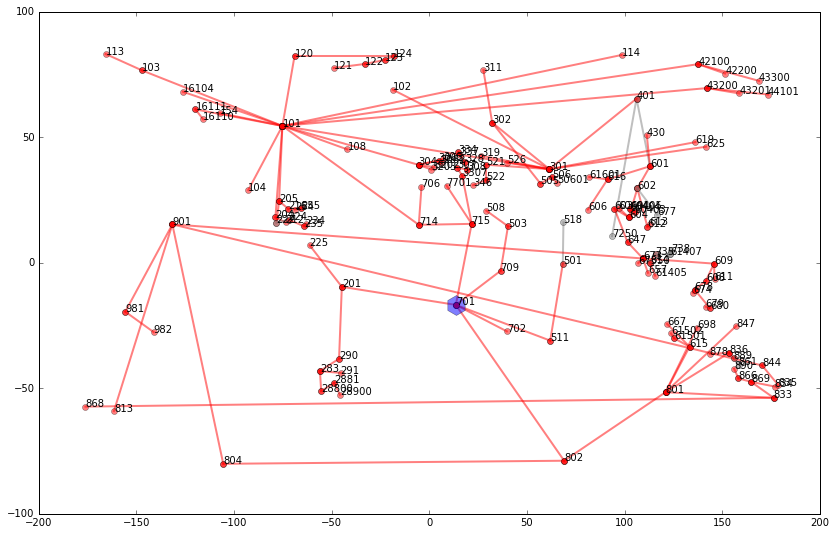

In [2]:
#rotation_model = pygplates.RotationModel('/Users/Simon/GIT/pygplates-alpha/tutorials-sv/Data/Seton_etal_ESR2012_2012.1.rot')
#tp = pygplates.FeatureCollection('/Users/Simon/GIT/pygplates-alpha/tutorials-sv/Data/Seton_etal_ESR2012_PP_2012.1.gpmlz')
#sp = pygplates.FeatureCollection('/Users/Simon/GIT/pygplates-alpha/tutorials-sv/Data/Seton_etal_ESR2012_StaticPolygons_2012.1.gpmlz')

rotation_model = pygplates.RotationModel('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot')
sp = pygplates.FeatureCollection('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/StaticPolygons/Muller_etal_AREPS_2016_StaticPolygons.gpmlz')



# Example #1, run code for one time snapshot and plot the results

recon_time = 50

#resolved_polygons = []
#pygplates.resolve_topologies(tp,rotation_model,resolved_polygons,recon_time)

reconstructed_static_polygons = []
pygplates.reconstruct(sp,rotation_model,reconstructed_static_polygons,recon_time)


uniq_plate_pairs_from_rotations = get_unique_plate_pairs_from_rotation_model(rotation_model,recon_time)

uniq_plates_from_static_polygons = get_unique_plate_ids_from_reconstructed_features(reconstructed_static_polygons)

chains = get_plate_chains(uniq_plates_from_static_polygons,uniq_plate_pairs_from_rotations)

print chains


plt.figure(figsize=(14,9))
for chain in chains:
    if chain[-1]==0:
        p0 = GetPolygonCentroid(reconstructed_static_polygons,chain[0])
        plt.plot(p0[1],p0[0],'bh',markersize=20,zorder=3,alpha=0.5)
        plt.text(p0[1],p0[0],str(chain[0]),zorder=4)
    else: 
        p0 = GetPolygonCentroid(reconstructed_static_polygons,chain[0])
        p1 = GetPolygonCentroid(reconstructed_static_polygons,chain[-1])

        if (len(p0)>0) & (len(p1)>0):  # in theory this if statement not needed now?
            if len(chain)==2:
                plt.plot([p0[1],p1[1]],[p0[0],p1[0]],'-ro',linewidth=2,zorder=1,alpha=0.5)
            else:
                plt.plot([p0[1],p1[1]],[p0[0],p1[0]],'-o',color='gray',linewidth=2,zorder=1,alpha=0.5)
            plt.text(p0[1],p0[0],str(chain[0]),zorder=2)

plt.show()



In [3]:
# Example #2
# Call the function for a series of times, append the results and save to a file for 
# viewing in GPlates
#
# use same method to generate a file with the line geometries, attributed
# with the fixed and moving plates (but not as gpml attributes, since we 
# don't want these to be used for reconstructions)

time_step = 1.
times = np.arange(0,201,time_step)

tree_features = None

for recon_time in times:
    
    print 'working on time %0.2f Ma' % recon_time
    
    reconstructed_static_polygons = []
    pygplates.reconstruct(sp,rotation_model,reconstructed_static_polygons,recon_time)

    uniq_plate_pairs_from_rotations = get_unique_plate_pairs_from_rotation_model(rotation_model,recon_time)

    uniq_plates_from_static_polygons = get_unique_plate_ids_from_reconstructed_features(reconstructed_static_polygons)

    chains = get_plate_chains(uniq_plates_from_static_polygons,uniq_plate_pairs_from_rotations)

    tree_features = create_hierarchy_features(chains,reconstructed_static_polygons,tree_features,
                                              valid_time=(recon_time+time_step/2.,recon_time-time_step/2.))


print 'Writing the file (patience may be required)....'
tree_feature_collection = pygplates.FeatureCollection(tree_features)
tree_feature_collection.write('hierarchies_test.gpmlz')
  

working on time 0.00 Ma
no fixed plate found for moving plate id 61501
no fixed plate found for moving plate id 69701
no fixed plate found for moving plate id 101
no fixed plate found for moving plate id 102
no fixed plate found for moving plate id 103
no fixed plate found for moving plate id 104
no fixed plate found for moving plate id 108
no fixed plate found for moving plate id 113
no fixed plate found for moving plate id 114
no fixed plate found for moving plate id 120
no fixed plate found for moving plate id 121
no fixed plate found for moving plate id 122
no fixed plate found for moving plate id 123
no fixed plate found for moving plate id 124
no fixed plate found for moving plate id 28800
no fixed plate found for moving plate id 154
no fixed plate found for moving plate id 61601
no fixed plate found for moving plate id 65702
no fixed plate found for moving plate id 43200
no fixed plate found for moving plate id 43201
no fixed plate found for moving plate id 201
no fixed plate fo